# A Causal Model of Simple Multiple Choice Question Answering 



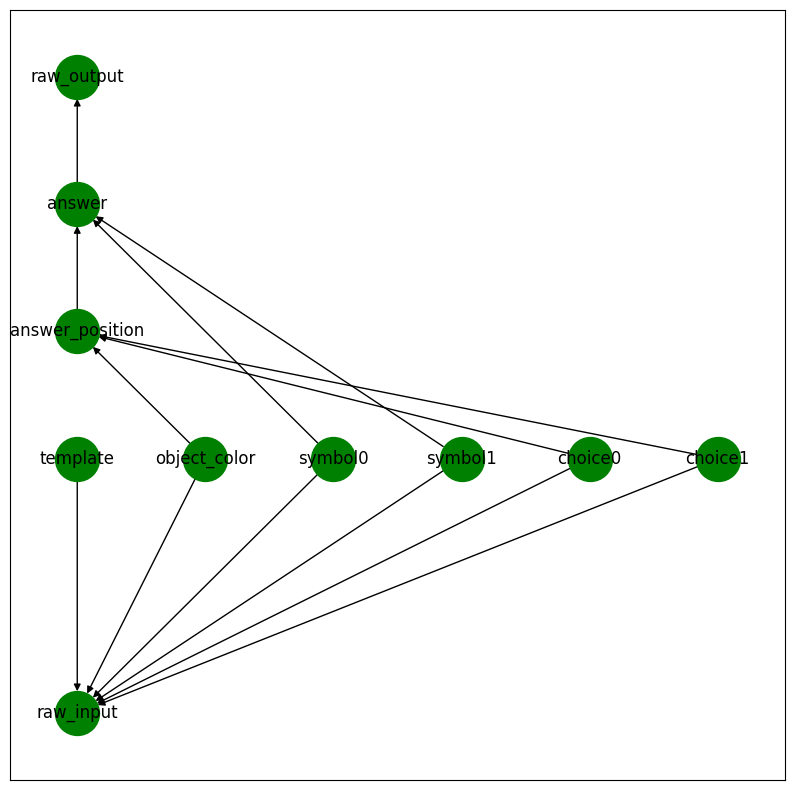

In [1]:
import sys
sys.path.append("..")

from causal.causal_model import CausalModel
import random
OBJECT_COLORS = [("banana", "yellow"), ("grass", "green"), ("strawberry", "red"), ("coconut", "brown"), ("eggplant", "purple"),
                 ("blueberry", "blue"), ("carrot", "orange"), ("coal", "black"), ("snow", "white"), ("ivory", "white"), ("cauliflower", "white"),
                 ("bubblegum", "pink"), ("lemon", "yellow"), ("lime", "green"), ("ruby", "red"), ("chocolate", "brown"), ("emerald", "green"), 
                 ("sapphire", "blue"), ("pumpkin", "orange")]
OBJECTS, COLORS= zip(*OBJECT_COLORS)

NUM_CHOICES = 2
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TEMPLATES = ["The <object> is <color>. What color is the <object>?" + "".join([f"\n<symbol{str(i)}>. <choice{str(i)}>" for i in range(NUM_CHOICES)]) + "\nAnswer:"]

variables = ["template", "object_color", "raw_input"] + ["symbol" + str(x) for x in range(NUM_CHOICES)] + ["choice" + str(x) for x in range(NUM_CHOICES)] + ["answer_position", "answer", "raw_output"]

values = {"choice" + str(x): COLORS for x in range(NUM_CHOICES)}
values.update({"symbol" + str(x): ALPHABET for x in range(NUM_CHOICES)})
values.update({"answer_position": range(NUM_CHOICES), "answer": ALPHABET})
values.update({"template": TEMPLATES})
values.update({"object_color": OBJECT_COLORS})
values.update({"raw_input": None, "raw_output": None})

parents = {
        "template": [],
        "object_color": [],
        "raw_input": ["template", "object_color"] + ["symbol" + str(x) for x in range(NUM_CHOICES)] + ["choice" + str(x) for x in range(NUM_CHOICES)],
        "answer_position": ["object_color"] + ["choice" + str(x) for x in range(NUM_CHOICES)],
        "answer": ["answer_position"] + ["symbol" + str(x) for x in range(NUM_CHOICES)], 
        "raw_output": ["answer"],
        }
parents.update({"choice" + str(x): [] for x in range(NUM_CHOICES)})
parents.update({"symbol" + str(x): [] for x in range(NUM_CHOICES)})

def fill_template(*args):
    template, object_color = args[0], args[1]
    symbols = args[2:2 + NUM_CHOICES]
    choices = args[2 + NUM_CHOICES:2 + 2 * NUM_CHOICES]

    object_name, color = object_color
    filled_template = template.replace("<object>", object_name).replace("<color>", color)
    for i, symbol in enumerate(symbols):
        filled_template = filled_template.replace(f"<symbol{i}>", symbol)
    for i, choice in enumerate(choices):
        filled_template = filled_template.replace(f"<choice{i}>", choice)
    return filled_template

def get_answer_position(object_color, *choices):
    for i, choice in enumerate(choices):
        if choice == object_color[1]:
            return i

def get_answer(answer_position, *symbols):
    if answer_position is None:
        return None
    return " " + symbols[answer_position]

mechanisms = {
    "template": lambda: random.choice(TEMPLATES),
    "object_color": lambda: random.choice(OBJECT_COLORS),
    **{f"symbol{i}": lambda: random.choice(ALPHABET) for i in range(NUM_CHOICES)},
    **{f"choice{i}": lambda: random.choice(COLORS) for i in range(NUM_CHOICES)},
    "raw_input": fill_template,
    "answer_position": get_answer_position,
    "answer": get_answer,
    "raw_output": lambda x: x,
}

MCQA_causal_model = CausalModel(variables, values, parents, mechanisms, id=f"{NUM_CHOICES}_answer_MCQA")
MCQA_causal_model.print_structure()

In [2]:
def sample_answerable_question():
    input = MCQA_causal_model.sample_input()
    #sample unique choices and symbols
    choices = random.sample(COLORS, NUM_CHOICES)
    symbols = random.sample(ALPHABET, NUM_CHOICES)
    for idx in range(NUM_CHOICES):
        input["choice" + str(idx)] = choices[idx]
        input["symbol" + str(idx)] = symbols[idx]
    if input["object_color"][1] not in [input["choice" + str(x)] for x in range(NUM_CHOICES)]:
        index = random.randint(0, NUM_CHOICES - 1)
        input["choice" + str(index)] = input["object_color"][1]
    return input

example = sample_answerable_question()
full_setting = MCQA_causal_model.run_forward(example)
print("Example input:")
for k, v in example.items():
    print(f"{k}: {v}")
print("\nFull setting:")
for k, v in full_setting.items():
    print(f"{k}: {v}")


Example input:
template: The <object> is <color>. What color is the <object>?
<symbol0>. <choice0>
<symbol1>. <choice1>
Answer:
object_color: ('grass', 'green')
symbol0: O
symbol1: C
choice0: green
choice1: pink

Full setting:
template: The <object> is <color>. What color is the <object>?
<symbol0>. <choice0>
<symbol1>. <choice1>
Answer:
object_color: ('grass', 'green')
symbol0: O
symbol1: C
choice0: green
choice1: pink
answer_position: 0
answer:  O
raw_input: The grass is green. What color is the grass?
O. green
C. pink
Answer:
raw_output:  O


# Constructing Counterfactual Datasets for a Causal Analysis

In [3]:
from causal.causal_model import CounterfactualDataset

def same_symbol_different_position():
    input = sample_answerable_question()
    counterfactual = input.copy()

    pos = MCQA_causal_model.run_forward(input)["answer_position"]
    new_pos = random.choice([i for i in range(NUM_CHOICES) if i != pos])
    counterfactual["choice" + str(pos)] = input["choice" + str(new_pos)]
    counterfactual["choice" + str(new_pos)] = input["choice" + str(pos)]
    counterfactual["symbol" + str(pos)] = input["symbol" + str(new_pos)]
    counterfactual["symbol" + str(new_pos)] = input["symbol" + str(pos)]
    input["raw_input"] = MCQA_causal_model.run_forward(input)["raw_input"]
    counterfactual["raw_input"] = MCQA_causal_model.run_forward(counterfactual)["raw_input"]
    return {"input":input, "counterfactual_inputs":[counterfactual]}

def different_symbol_same_position():
    input = sample_answerable_question()
    counterfactual = input.copy()
    current_symbols = [input["symbol" + str(i)] for i in range(NUM_CHOICES)]
    complement = [ x for x in ALPHABET if x not in current_symbols]
    #choose from the complement without replacement
    new_symbols = random.sample(complement, NUM_CHOICES)
    for i in range(NUM_CHOICES):
        counterfactual["symbol" + str(i)] = new_symbols[i]
    input["raw_input"] = MCQA_causal_model.run_forward(input)["raw_input"]
    counterfactual["raw_input"] = MCQA_causal_model.run_forward(counterfactual)["raw_input"]
    return {"input":input, "counterfactual_inputs":[counterfactual]}

def different_symbol_different_position():
    input = sample_answerable_question()
    counterfactual = input.copy()

    #Different position
    pos = MCQA_causal_model.run_forward(input)["answer_position"]
    new_pos = random.choice([i for i in range(NUM_CHOICES) if i != pos])
    counterfactual["choice" + str(pos)] = input["choice" + str(new_pos)]
    counterfactual["choice" + str(new_pos)] = input["choice" + str(pos)]

    #Different symbol
    current_symbols = [input["symbol" + str(i)] for i in range(NUM_CHOICES)]
    complement = [ x for x in ALPHABET if x not in current_symbols]
    new_symbols = random.sample(complement, NUM_CHOICES)
    for i in range(NUM_CHOICES):
        counterfactual["symbol" + str(i)] = new_symbols[i]

    input["raw_input"] = MCQA_causal_model.run_forward(input)["raw_input"]
    counterfactual["raw_input"] = MCQA_causal_model.run_forward(counterfactual)["raw_input"]
    return {"input":input, "counterfactual_inputs":[counterfactual]}

def random_counterfactual():
    input, counterfactual = sample_answerable_question(), sample_answerable_question()
    input["raw_input"] = MCQA_causal_model.run_forward(input)["raw_input"]
    counterfactual["raw_input"] = MCQA_causal_model.run_forward(counterfactual)["raw_input"]
    return {"input":input, "counterfactual_inputs":[counterfactual]}

counterfactual_datasets = { "same_symbol_different_position": CounterfactualDataset.from_sampler(100, same_symbol_different_position), 
                            "different_symbol_different_position": CounterfactualDataset.from_sampler(100, different_symbol_different_position), 
                            "different_symbol_same_position": CounterfactualDataset.from_sampler(100, different_symbol_same_position), 
                            "random_counterfactual": CounterfactualDataset.from_sampler(100, random_counterfactual) }

for name, dataset in counterfactual_datasets.items():
    example = dataset[0]
    print(f"\nCounterfactual dataset: {name}")
    print("\nExample input:")
    for k, v in example["input"].items():
        print(f"{k}: {v}")
    print("\nCounterfactual example:")
    for k, v in example["counterfactual_inputs"][0].items():
        print(f"{k}: {v}")
    print("--" * 20)


Counterfactual dataset: same_symbol_different_position

Example input:
choice0: red
choice1: black
object_color: ['coal', 'black']
raw_input: The coal is black. What color is the coal?
F. red
R. black
Answer:
symbol0: F
symbol1: R
template: The <object> is <color>. What color is the <object>?
<symbol0>. <choice0>
<symbol1>. <choice1>
Answer:

Counterfactual example:
choice0: black
choice1: red
object_color: ['coal', 'black']
raw_input: The coal is black. What color is the coal?
R. black
F. red
Answer:
symbol0: R
symbol1: F
template: The <object> is <color>. What color is the <object>?
<symbol0>. <choice0>
<symbol1>. <choice1>
Answer:
----------------------------------------

Counterfactual dataset: different_symbol_different_position

Example input:
choice0: white
choice1: white
object_color: ['cauliflower', 'white']
raw_input: The cauliflower is white. What color is the cauliflower?
Z. white
B. white
Answer:
symbol0: Z
symbol1: B
template: The <object> is <color>. What color is the <

# Loading in a Language Model

In [4]:
from neural.pipeline import LMPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct" 
pipeline = LMPipeline(model_name, max_new_tokens=1, device=device, dtype=torch.float16)
pipeline.tokenizer.padding_side = "left"
print("DEVICE:", pipeline.model.device)

# Get a sample input and check model's prediction
sampled_example = next(iter(counterfactual_datasets.values()))[0]
print("INPUT:", sampled_example["input"])
print("EXPECTED OUTPUT:", MCQA_causal_model.run_forward(sampled_example["input"])["raw_output"])
print("MODEL PREDICTION:", pipeline.dump(pipeline.generate(sampled_example["input"])))


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

DEVICE: cuda:0
INPUT: {'choice0': 'red', 'choice1': 'black', 'object_color': ['coal', 'black'], 'raw_input': 'The coal is black. What color is the coal?\nF. red\nR. black\nAnswer:', 'symbol0': 'F', 'symbol1': 'R', 'template': 'The <object> is <color>. What color is the <object>?\n<symbol0>. <choice0>\n<symbol1>. <choice1>\nAnswer:'}
EXPECTED OUTPUT:  R


/home/atticus/miniconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/atticus/miniconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


MODEL PREDICTION:  R


# Filtering Examples the Language Model Fails On

In [5]:
from experiments.filter_experiment import FilterExperiment
def checker(neural_output, causal_output):
    return neural_output in causal_output
# Filter the datasets based on model performance
print("\nFiltering datasets based on model performance...")
exp = FilterExperiment(pipeline, MCQA_causal_model, checker)
filtered_datasets = exp.filter(counterfactual_datasets, verbose=True, batch_size=128)


Filtering datasets based on model performance...


Filtering same_symbol_different_position: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Dataset 'same_symbol_different_position': kept 97/100 examples (97.0%)


Filtering different_symbol_different_position: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Dataset 'different_symbol_different_position': kept 97/100 examples (97.0%)


Filtering different_symbol_same_position: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Dataset 'different_symbol_same_position': kept 100/100 examples (100.0%)


Filtering random_counterfactual: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Dataset 'random_counterfactual': kept 100/100 examples (100.0%)

Total filtering results:
Original examples: 400
Kept examples: 394
Overall keep rate: 98.5%


# Definition token positions of interest

In [6]:
from neural.LM_units import TokenPosition, get_last_token_index
import re

def get_correct_symbol_index(input, pipeline, causal_model):
    """
    Find the index of the correct answer symbol in the prompt.
    
    Args:
        input (Dict): The input dictionary to a causal model
        pipeline: The tokenizer pipeline
        
    Returns:
        list[int]: List containing the index of the correct answer symbol token
    """
    # Run the model to get the answer position
    output = causal_model.run_forward(input)
    pos = output["answer_position"]
    correct_symbol = output[f"symbol{pos}"]
    prompt = input["raw_input"]
    
    # Find all single uppercase letters in the prompt
    matches = list(re.finditer(r"\b[A-Z]\b", prompt))
    
    # Find the match corresponding to our correct symbol
    symbol_match = None
    for match in matches:
        if prompt[match.start():match.end()] == correct_symbol:
            symbol_match = match
            break
            
    if not symbol_match:
        raise ValueError(f"Could not find correct symbol {correct_symbol} in prompt: {prompt}")
    
    # Get the substring up to the symbol match end
    substring = prompt[:symbol_match.end()]
    tokenized_substring = list(pipeline.load(substring)["input_ids"][0])
    
    # The symbol token will be at the end of the substring
    return [len(tokenized_substring) - 1]

# Create TokenPosition object
token_positions = [
    TokenPosition(lambda x: get_correct_symbol_index(x, pipeline, MCQA_causal_model), pipeline, id="correct_symbol"),
    TokenPosition(lambda x: [get_correct_symbol_index(x, pipeline, MCQA_causal_model)[0]+1], pipeline, id="correct_symbol_period"),
    TokenPosition(lambda x: get_last_token_index(x, pipeline), pipeline, id="last_token")
]

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [7]:
from experiments.residual_stream_experiment import PatchResidualStream

start = 0
end = pipeline.get_num_layers()
config = {"batch_size":128}
target_variables_list  = [["answer"], ["answer_position"]]
results_dir = "MCQA_demo_results"



In [8]:

experiment = PatchResidualStream(pipeline, MCQA_causal_model, list(range(start, end)), token_positions, checker, config=config)
raw_results = experiment.perform_interventions(counterfactual_datasets, verbose=True, target_variables_list=target_variables_list, save_dir=results_dir)

Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:correct_symbol)')]]


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]/home/atticus/miniconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/atticus/miniconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for same_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_different_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for different_symbol_same_position with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:0,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:1,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:2,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:3,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:4,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:5,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:6,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:7,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:8,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:9,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:10,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:11,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:12,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:13,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:14,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:15,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:16,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:17,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:18,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:19,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:20,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:21,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:22,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:23,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:24,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:25,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:26,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:27,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:28,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:29,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:30,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:correct_symbol)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:correct_symbol_period)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Running interventions for random_counterfactual with model units [[AtomicModelUnit(id='ResidualStream(Layer:31,Token:last_token)')]]


Processing batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]



Heatmaps for 'answer' variable:


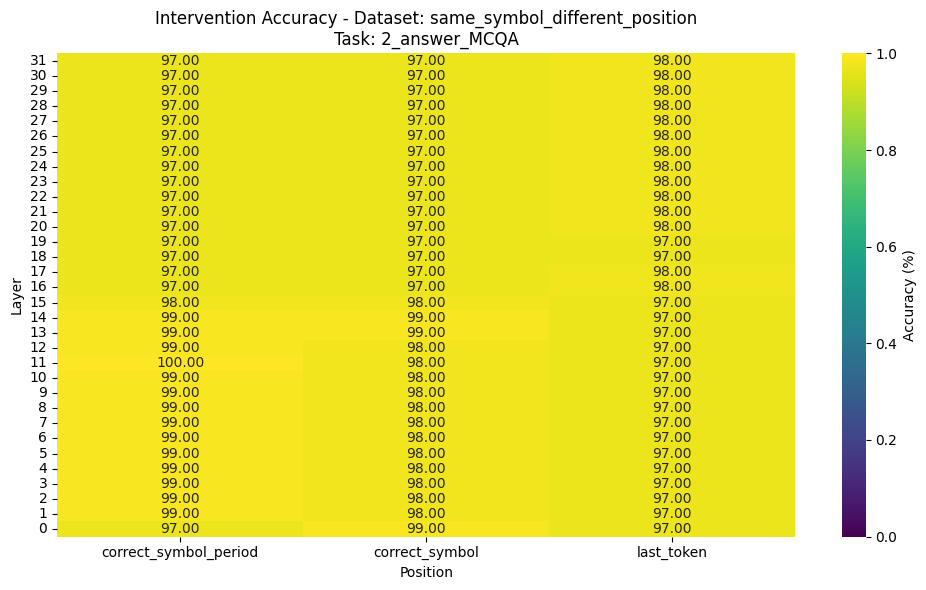

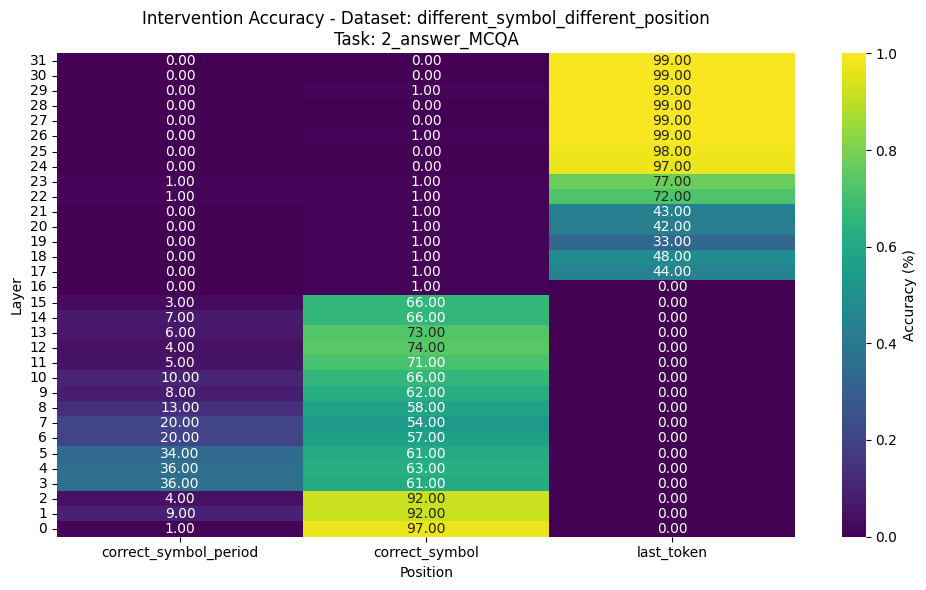

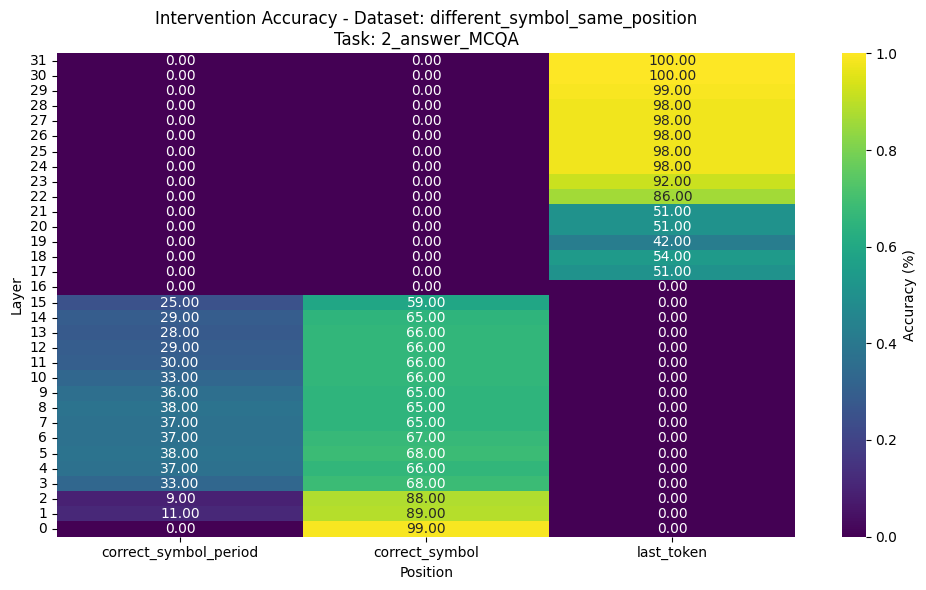

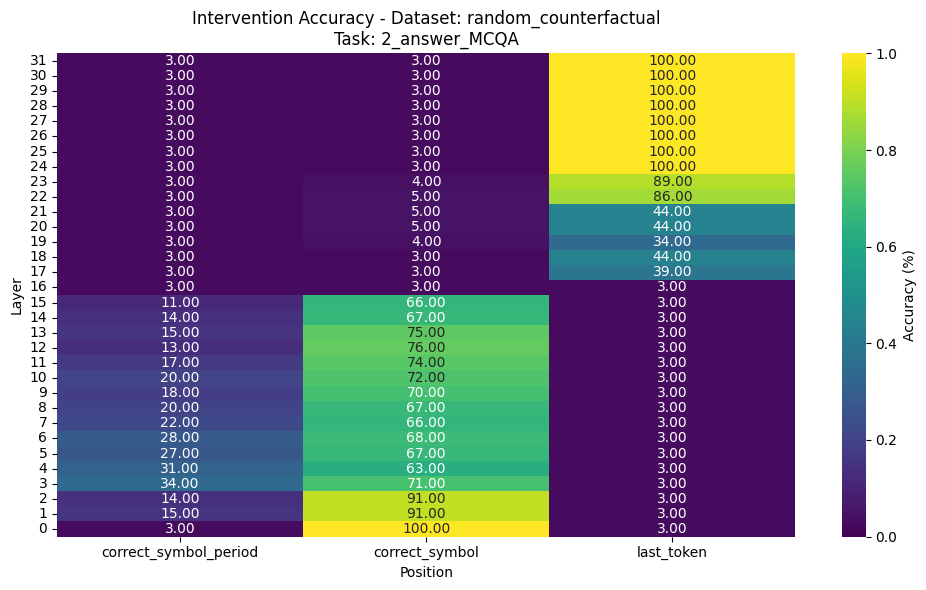


Heatmaps for 'answer_position' variable:


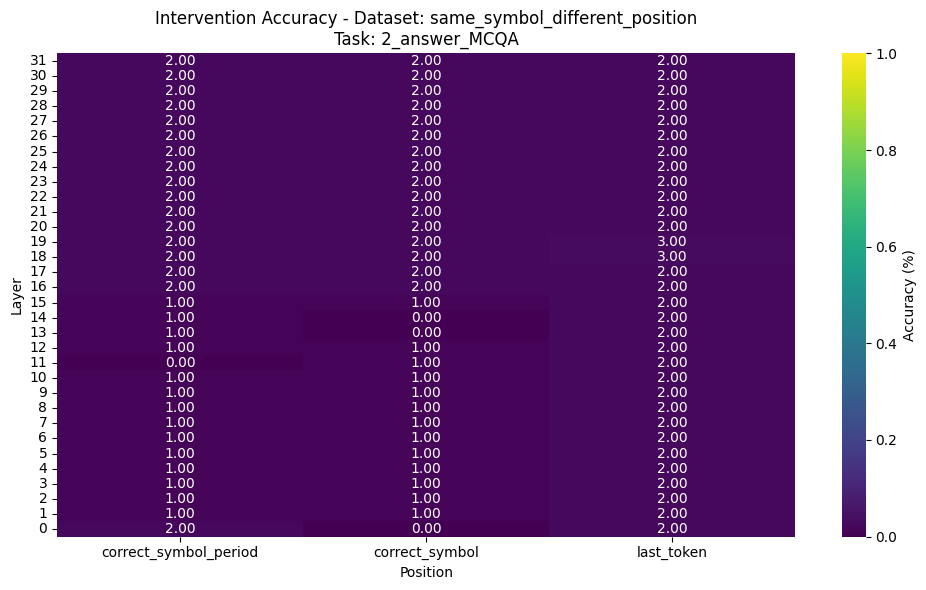

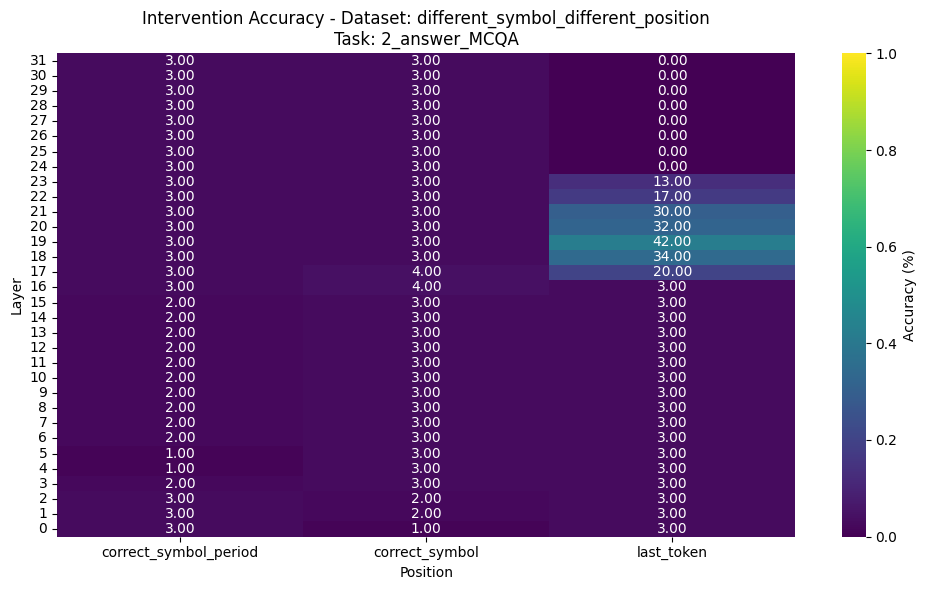

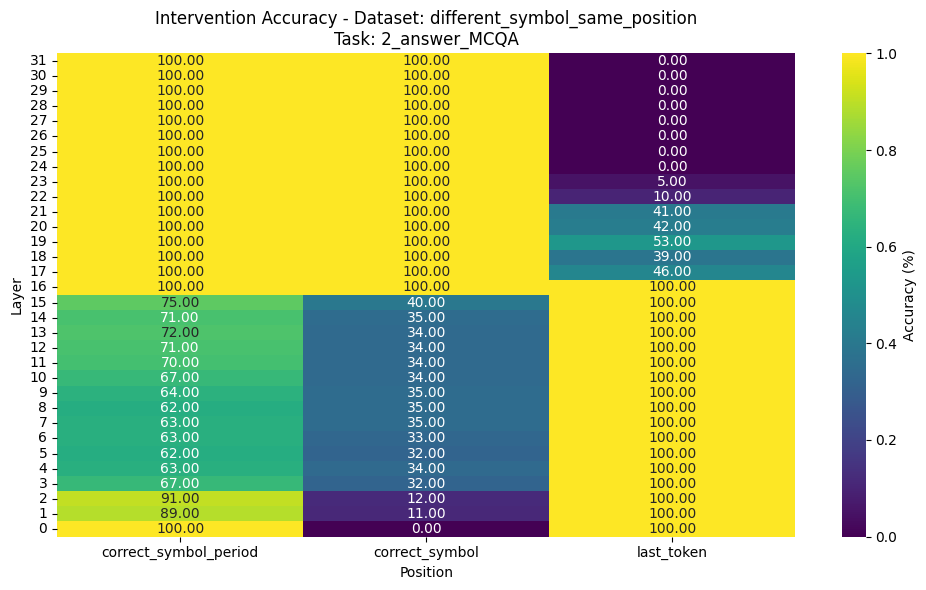

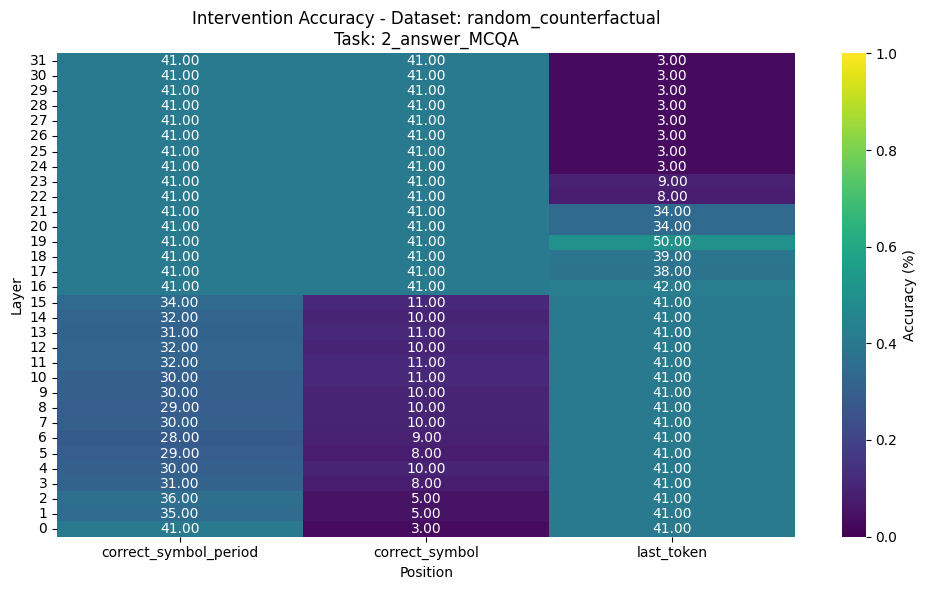

In [9]:
print("\nHeatmaps for 'answer' variable:")
experiment.plot_heatmaps(raw_results, ["answer"])
print("\nHeatmaps for 'answer_position' variable:")
experiment.plot_heatmaps(raw_results, ["answer_position"])

# Train Featurizers with DAS

For each token position and model layer we train a set of 16 orthogonal linear features to realize the answer_position variable in the causal model. 
We again perform interchange interventions on the causal model and the language model, but we will now use the output of the causal model under intervention
as a source of supervision to learn where to intervene in the language model. Instead of intervening on the full 
residual stream vector of the language model, we intervene on a linear subspace that is parameterized using 16 orthogonal vectors. Then we update
these orthogonal vectors such that the output of the LM under interchange intervention is the same as the output of the causal model under interchange intervention.

In [ ]:
config = {
    "batch_size": 16, 
    "evaluation_batch_size": 128, 
    "training_epoch": 8, 
    "n_features": 16, 
}
experiment = PatchResidualStream(pipeline, MCQA_causal_model, list(range(start, end)), token_positions, checker, config=config)
experiment.train_interventions(counterfactual_datasets, ["answer_position"], method="DAS", verbose=True)
raw_results = experiment.perform_interventions(counterfactual_datasets, verbose=True, target_variables_list=target_variables_list, save_dir=results_dir)

In [ ]:
print("\nHeatmaps for 'answer_position' variable:")
experiment.plot_heatmaps(raw_results, ["answer_position"])